# MCMC testing notebook: Pymc using DE-MCMC

This notebook tests the implmentation of Pymc using the finite-difference model. The intention is for an example that runs relatively quickly, so the number of effective samples may be insufficient for proper analysis. 


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import corner

import pytensor.tensor as tt
import pymc as pm
import arviz as az

from advdiff_mcmc.advdiff.fd_utils import generate_grid, calc_Ks, calc_Ks_new
from advdiff_mcmc.advdiff.fdm_implement import obj_CN
from advdiff_mcmc.mcmc.mcmc_sampling import my_loglike, LogLike


sns.set()
sns.set_style("white")
sns.set_style("ticks")

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

## Create the synthetic forcing data

In [2]:
del_z = 1.0
h_tot = 16.0

del_t = 300.0
T_tot = 12*60*60

bbl_h = 15

km_bg = 10**-4

fg, mg, tg = generate_grid(h_tot, del_z, T_tot, del_t) 
print('Grid size = ', str(len(mg)), ' x ', str(len(tg)))

# lmbda, alpha, beta = CN_coefficients(tg, mg)

Grid size =  16  x  145


In [3]:
# Specify a u* time series for diffusivity profile
f_wave = 0.17*np.sin(np.linspace(-np.pi/2,3.5*np.pi,len(tg))) + 0.20

u_bed = np.sqrt((f_wave)**2 * 0.00185)
t_bed = 1035*u_bed**2

# Calculate diffusivity profile
Ks_all = calc_Ks(u_bed, fg, np.repeat(bbl_h, len(tg)), km_bg)
Ks_new = calc_Ks_new(u_bed, fg, np.repeat(bbl_h, len(tg)), km_bg)

## Create the synthetic SSC data

#### Pick some realistic parameters from literature

In [4]:
w_s = 1.0 # [x10-3 m/s]
t_c = 7.0 # [x10-2 Pa]
e_0 = 3.0 # [x10-4 g/m2/s]
m_c = None
b_c = 1.1 # close to one makes the model difficult to sample

theta_syn = [w_s, e_0, t_c, m_c, b_c, 0]


In [5]:
# Run the model once to get initial profile
model_spec = [tg, mg, fg, np.zeros_like(mg), Ks_all, h_tot, t_bed]

syn_init = obj_CN(theta_syn, 'E1', model_spec)
cn_rn = syn_init[-1,:]

# Run the model again to get the final synthetic data
model_spec = [tg, mg, fg, cn_rn, Ks_all, h_tot, t_bed]
syn_final = obj_CN(theta_syn, 'E1', model_spec)

obs_htx = ((mg >= 0.4) & (mg <= 0.6)) | ((mg >= 8.4) & (mg <= 8.6))

## Add noise to the synthetic SSC


In [6]:
obs_mod = np.copy(syn_final)

noise_sd = 2/1000
noise_meas = np.random.normal(0, noise_sd, np.shape(obs_mod))
obs_meas = obs_mod + noise_meas

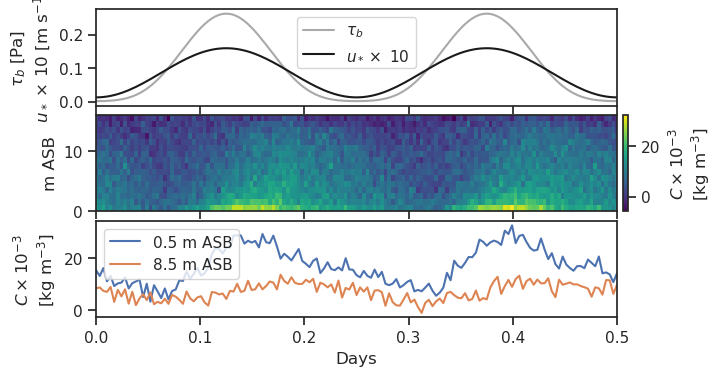

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(8,4))
plt.subplots_adjust(hspace=0.1)

ax[0].plot(tg/60/60/24, t_bed, label='$\\tau_b$', c='darkgrey')
ax[0].plot(tg/60/60/24, 10*u_bed, label=r'$u_* \times$ 10', c='k')

ax[0].set_ylabel('$\\tau_b$ [Pa]\n $u_*$ $\\times$ 10 [m s$^{-1}$]')
ax[0].legend()

pc=ax[1].pcolormesh(tg/60/60/24, mg, 1000*obs_meas.T, cmap=cm.viridis)
cb2 = fig.colorbar(pc, ax=ax[1], pad=0.01)
mpl.colorbar.ColorbarBase.set_label(cb2, '$C \\times 10^{-3}$\n[kg m$^{-3}$]')

ax[1].set_ylabel('m ASB')
ax[2].plot(tg/60/60/24, obs_meas.T[obs_htx][0]*1000, label=str(mg[obs_htx][0]) + ' m ASB')
ax[2].plot(tg/60/60/24, obs_meas.T[obs_htx][-1]*1000, label=str(mg[obs_htx][-1]) + ' m ASB')
ax[2].legend()

ax[2].set_ylabel('$C \\times 10^{-3}$\n[kg m$^{-3}$]')
ax[2].set_xlabel('Days')

ax_zero = ax[1].get_position().bounds
for x in ax:
    x.set_xlim(0, tg[-1]/60/60/24)
    if x != ax[-1]:
        x.set_xlabel('')
        x.set_xticklabels('')

    if x != ax[1]:
        ax_one = x.get_position().bounds
        x.set_position([ax_zero[0], ax_one[1], ax_zero[2], ax_one[3]])

# Test the inference method: DE-MCMC

In [8]:
# Create operation
logl = LogLike(my_loglike, obs_meas, 'E1', model_spec, obs_htx)

# Create model and set priors
with pm.Model() as model:
    w_s_pdf = pm.Lognormal('w_s', mu=0.5, sigma=0.7)
    e_0_pdf = pm.HalfNormal('e_0', 2.)
    t_c_pdf = pm.HalfNormal('t_c', 2.)
    m_c_pdf = 0.0 # pm.HalfNormal('m_c', 5.)
    b_c_pdf = pm.Lognormal('b_c', mu=-0.2, sigma=0.4)
    sig_pdf = pm.HalfNormal('sig_mod', 3.)

    # # Convert parameters to a tensor vector
    theta = tt.as_tensor_variable([w_s_pdf, e_0_pdf, t_c_pdf, m_c_pdf, b_c_pdf, sig_pdf])
    
    # Specify custom log-likelihood (standard Guassian that takes numerical model output - see edge_funcs.py)
    pm.Potential('likelihood', logl(theta))
    
    # # Save log-likelihood value (extra step - increases run time)
    # llk = pm.Deterministic('logp', model.logp)

In [9]:
with model:
    trace_MAP = pm.find_MAP()
trace_MAP

{'w_s_log__': array(0.01975043),
 'e_0_log__': array(0.80672367),
 't_c_log__': array(2.08855465),
 'b_c_log__': array(-0.11499004),
 'sig_mod_log__': array(0.69177589),
 'w_s': array(1.01994676),
 'e_0': array(2.24055515),
 't_c': array(8.07323809),
 'b_c': array(0.89137502),
 'sig_mod': array(1.99725929)}

In [10]:
# Run a quick test
with model:
    trace_norm = pm.sample(10000, step=pm.DEMetropolis(), chains=6, tune=3000,\
                           cores=3, compute_convergence_checks=False)

In [ ]:
inf_obj = pm.to_inference_data(trace_norm)

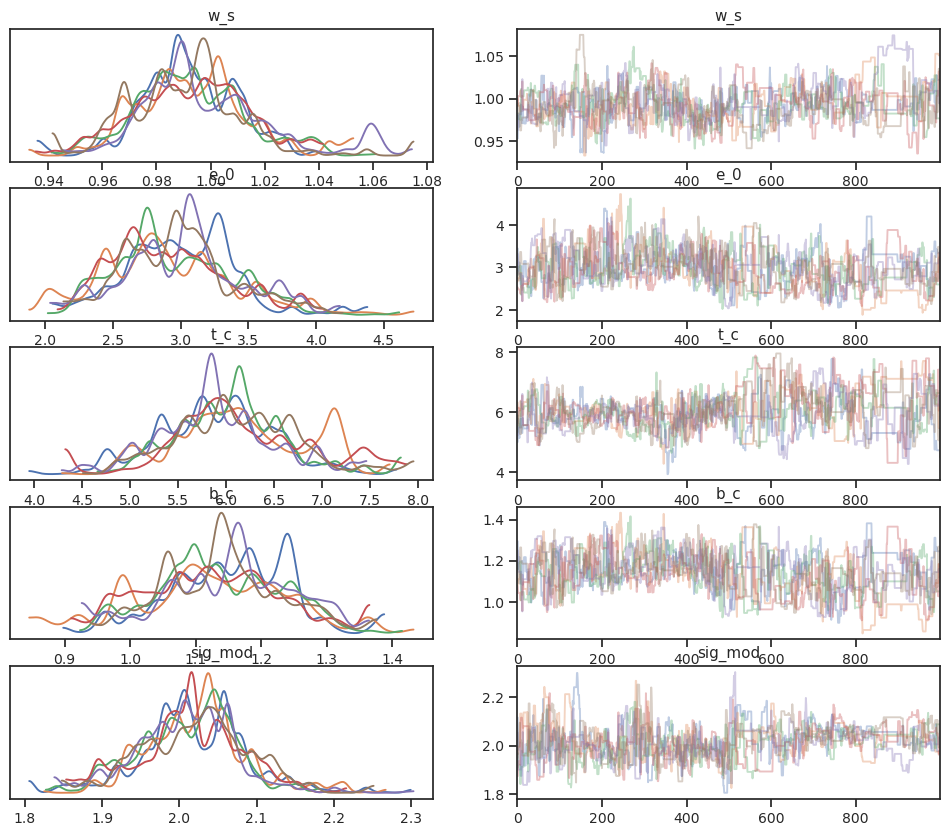

In [ ]:
with model:
    _=az.plot_trace(inf_obj, compact=False)

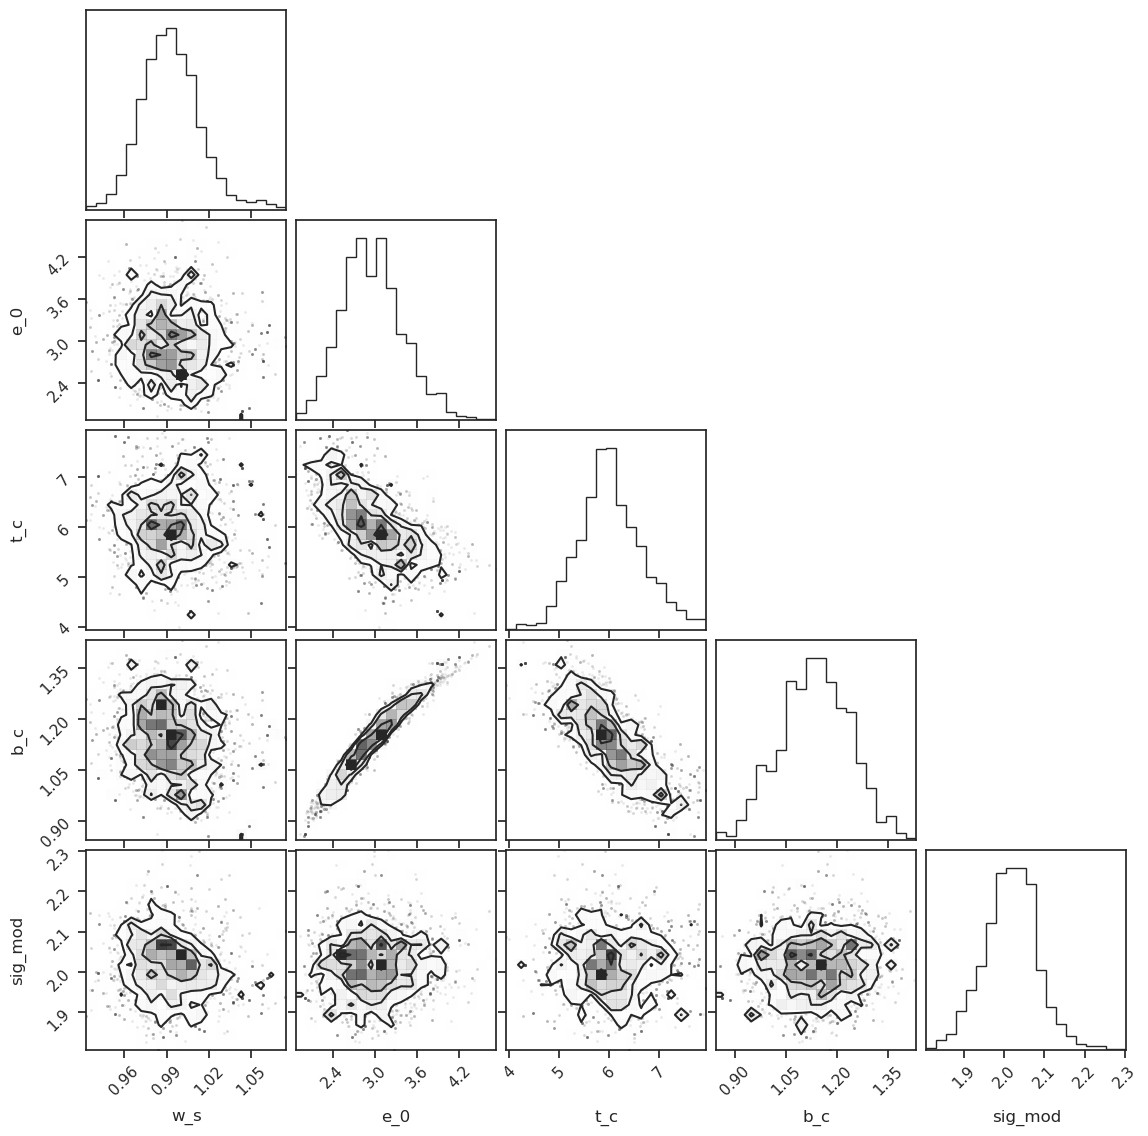

In [ ]:
_=corner.corner(inf_obj)

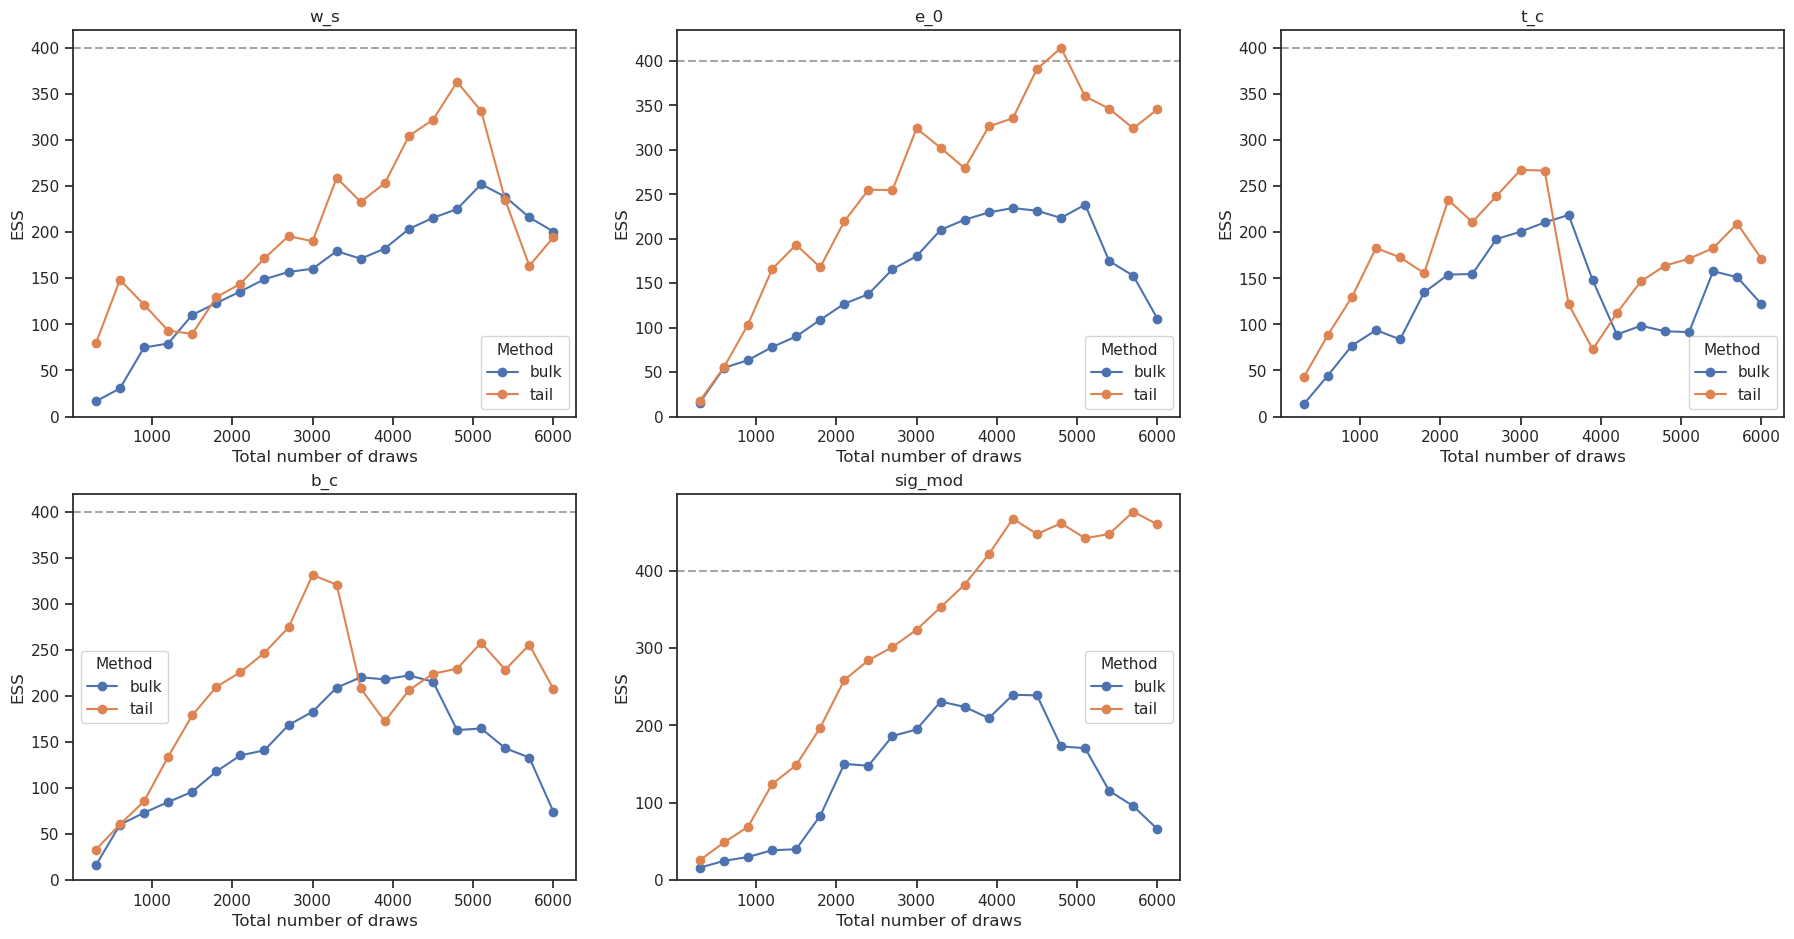

In [ ]:
_=az.plot_ess(inf_obj, kind="evolution")

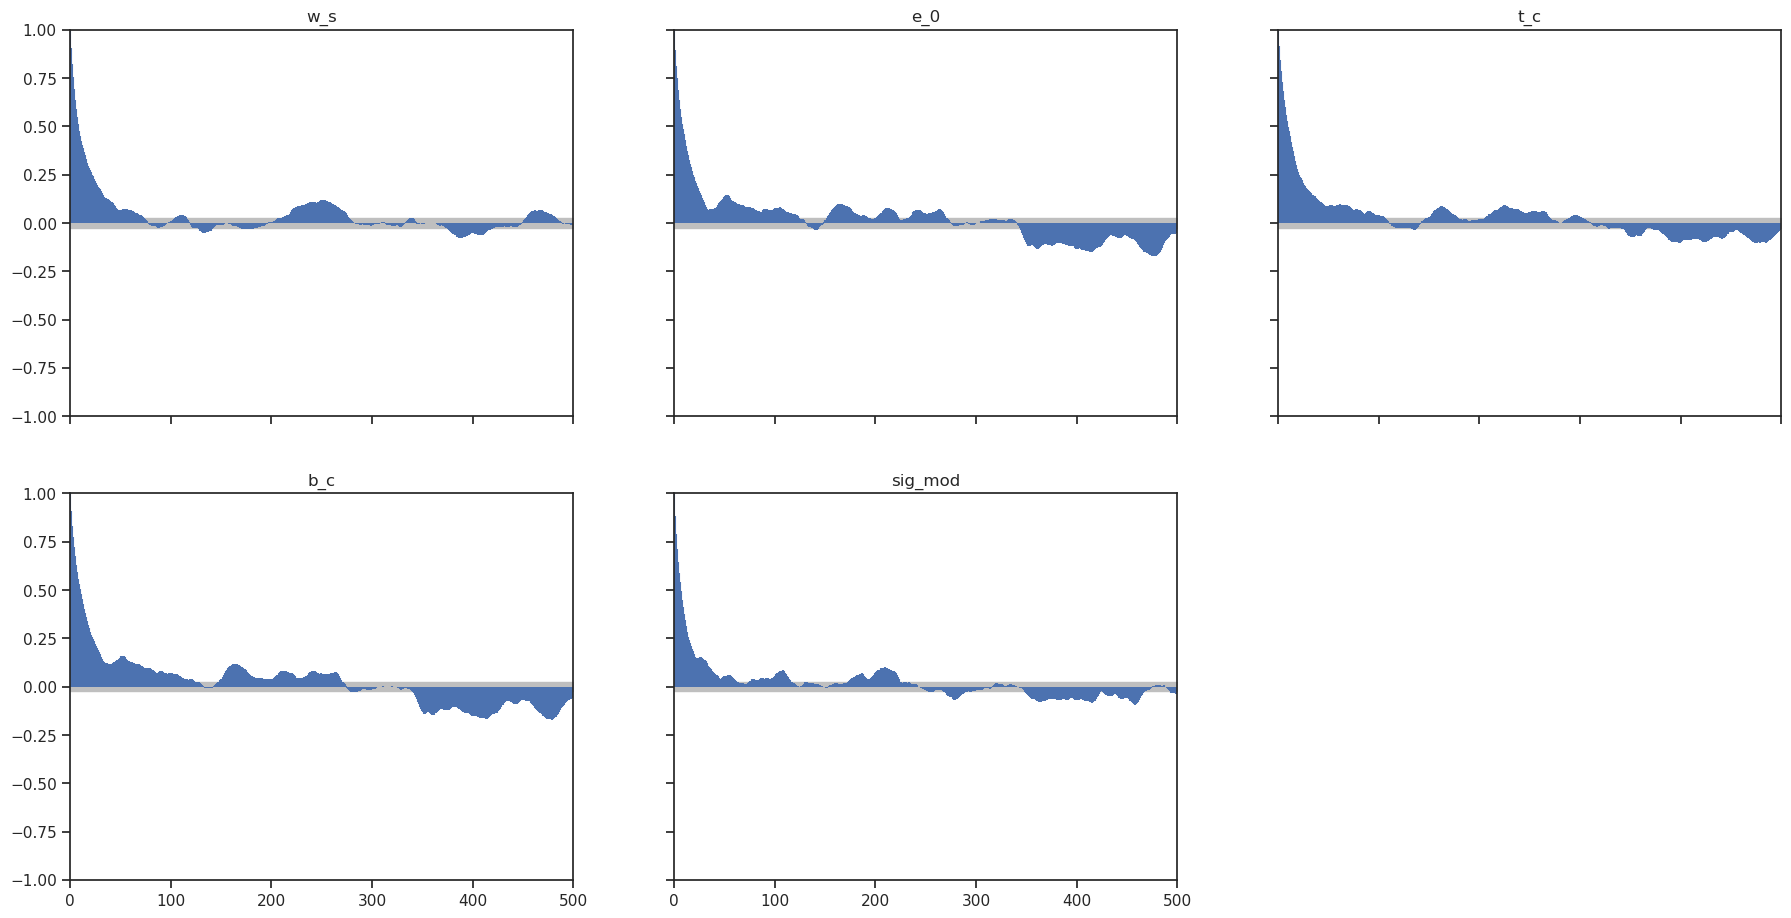

In [ ]:
_=az.plot_autocorr(inf_obj, combined=True, max_lag=500)

#### Needs a longer tune and more samples to get above some basic requirements, but the idea is there. Chain auto-correlationa and ESS remain somewhat of an issue. 